## Imports

In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt
from torchvision import transforms
from torchmetrics.classification import BinaryJaccardIndex
from PIL import Image
import ipywidgets as widgets
from IPython.display import display
import io

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data Augmentation & Preperation

In [2]:

class FruitDataset(Dataset):
    def __init__(self, image_dir, mask_dir, augment=False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = sorted(os.listdir(image_dir))

        # Data Augmentation
        if augment:
            self.transform_img = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(30),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                transforms.ToTensor()
            ])
        else:
            self.transform_img = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.ToTensor()
            ])

        self.transform_mask = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_name = self.images[idx]
        img_path = os.path.join(self.image_dir, image_name)
        mask_name = os.path.splitext(image_name)[0] + ".png"
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = Image.open(img_path).convert("RGB")
        if os.path.exists(mask_path):
            mask = Image.open(mask_path).convert("L")
        else:
            mask = Image.new("L", (256, 256), 0)

        image = self.transform_img(image)
        mask = self.transform_mask(mask)
        mask = (mask > 0.05).float()

        return image, mask


## Dice Loss / UNet architecture

In [3]:
# Dice Loss
class DiceLoss(nn.Module):
    def forward(self, inputs, targets, smooth=1e-6):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        return 1 - (2.*intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

# U-Net
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        def block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True)
            )
        self.encoder1 = block(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.middle = block(128, 256)
        self.up1 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.decoder1 = block(256, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.decoder2 = block(128, 64)
        self.out = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool1(e1))
        m = self.middle(self.pool2(e2))
        d1 = self.decoder1(torch.cat([self.up1(m), e2], dim=1))
        d2 = self.decoder2(torch.cat([self.up2(d1), e1], dim=1))
        return torch.sigmoid(self.out(d2))


## Model Training

In [4]:
base_path = r"E:\eatfresh_final\eatfresh\THEDATASET"
train_dataset = FruitDataset(os.path.join(base_path, "train/images"), os.path.join(base_path, "train/masks"))
val_dataset = FruitDataset(os.path.join(base_path, "val/images"), os.path.join(base_path, "val/masks"))
test_dataset = FruitDataset(os.path.join(base_path, "test/images"), os.path.join(base_path, "test/masks"))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Training
model = UNet().to(device)
bce_loss = nn.BCELoss()
dice_loss = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 40

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = 0.5 * bce_loss(outputs, masks) + 0.5 * dice_loss(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            val_loss = 0.5 * bce_loss(outputs, masks) + 0.5 * dice_loss(outputs, masks)
            running_val_loss += val_loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

torch.save(model.state_dict(), "unet_model.pth")

def evaluate_iou(loader):
    model.eval()
    metric = BinaryJaccardIndex().to(device)
    iou_scores = []

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = (outputs > 0.5).float()
            iou = metric(preds, masks)
            iou_scores.append(iou.item())
    return np.mean(iou_scores)



Epoch [1/40], Train Loss: 0.5799, Val Loss: 0.5913
Epoch [2/40], Train Loss: 0.5385, Val Loss: 0.5801
Epoch [3/40], Train Loss: 0.5021, Val Loss: 0.5675
Epoch [4/40], Train Loss: 0.4843, Val Loss: 0.5880
Epoch [5/40], Train Loss: 0.4699, Val Loss: 0.5395
Epoch [6/40], Train Loss: 0.4472, Val Loss: 0.5562
Epoch [7/40], Train Loss: 0.4286, Val Loss: 0.5207
Epoch [8/40], Train Loss: 0.4138, Val Loss: 0.5308
Epoch [9/40], Train Loss: 0.4011, Val Loss: 0.5065
Epoch [10/40], Train Loss: 0.3993, Val Loss: 0.5018
Epoch [11/40], Train Loss: 0.3869, Val Loss: 0.5097
Epoch [12/40], Train Loss: 0.3855, Val Loss: 0.4943
Epoch [13/40], Train Loss: 0.3773, Val Loss: 0.4914
Epoch [14/40], Train Loss: 0.3814, Val Loss: 0.4993
Epoch [15/40], Train Loss: 0.3709, Val Loss: 0.4872
Epoch [16/40], Train Loss: 0.3611, Val Loss: 0.5555
Epoch [17/40], Train Loss: 0.3584, Val Loss: 0.5091
Epoch [18/40], Train Loss: 0.3533, Val Loss: 0.4952
Epoch [19/40], Train Loss: 0.3499, Val Loss: 0.4788
Epoch [20/40], Train 

## Evaluation 

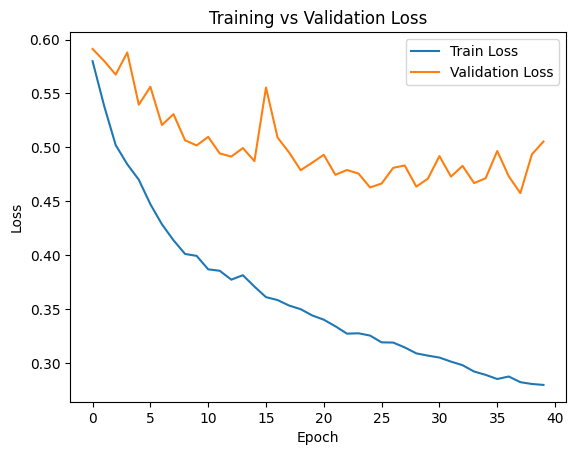

Train IOU: 0.4978
Val IOU: 0.2229
Test IOU: 0.2279


In [5]:
train_iou = evaluate_iou(train_loader)
val_iou = evaluate_iou(val_loader)
test_iou = evaluate_iou(test_loader)

# Loss Graph
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

# IOU Results
print(f"Train IOU: {train_iou:.4f}")
print(f"Val IOU: {val_iou:.4f}")
print(f"Test IOU: {test_iou:.4f}")

## Visualisation

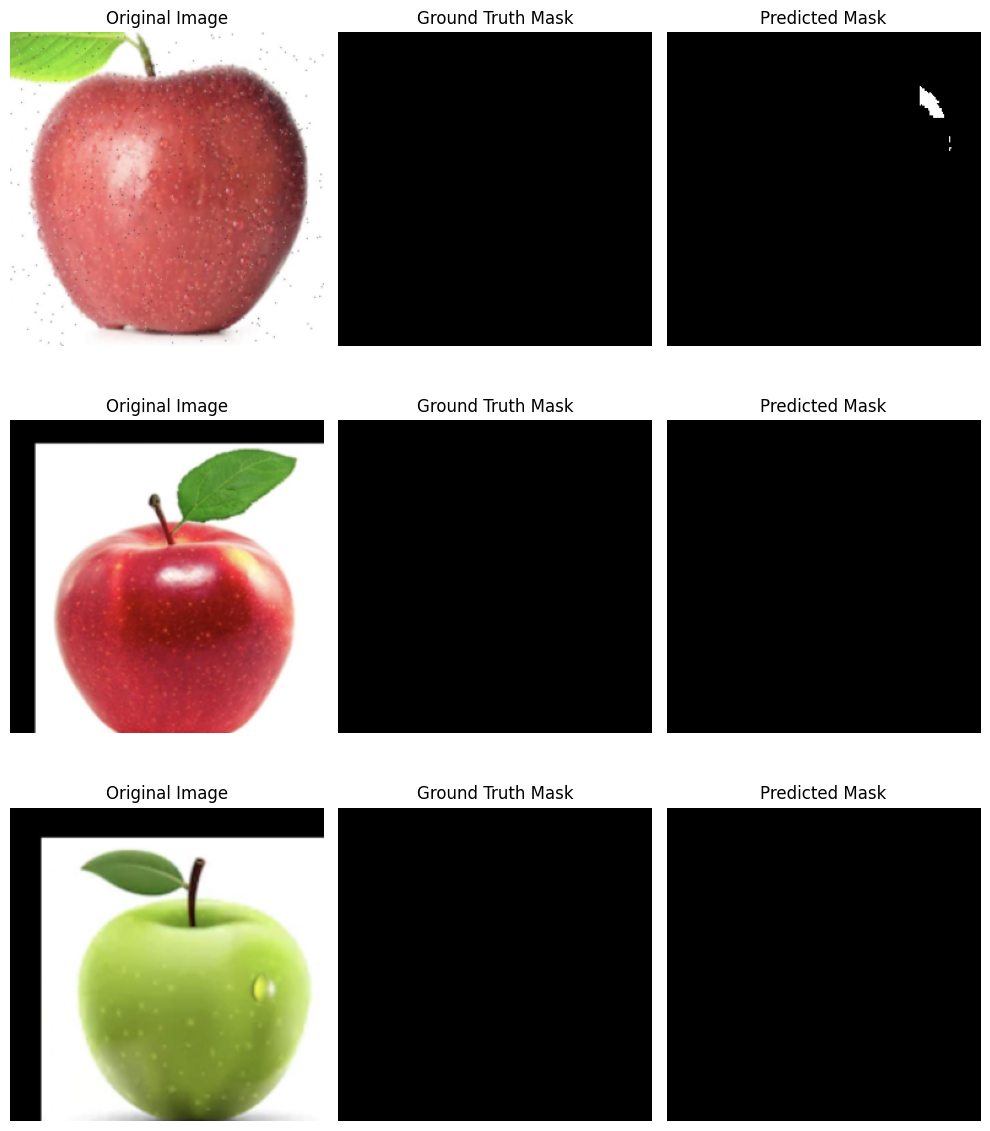

In [6]:
def visualize_predictions(dataset, num_samples=3):
    model.to(device)
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(10, 4 * num_samples))
    
    for i in range(num_samples):
        image, mask = dataset[i]

        image = image.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(image).squeeze().cpu().numpy()

        pred_mask = (output > 0.5).astype(np.uint8)
        image_np = image.squeeze(0).cpu().permute(1, 2, 0).numpy()
        
        axes[i, 0].imshow(image_np)
        axes[i, 0].set_title("Original Image")
        axes[i, 1].imshow(mask.squeeze(), cmap='gray')
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 2].imshow(pred_mask, cmap='gray')
        axes[i, 2].set_title("Predicted Mask")

        for ax in axes[i]:
            ax.axis('off')

    plt.tight_layout()
    plt.show()
visualize_predictions(val_dataset, num_samples=3)


FileUpload(value=(), accept='.jpg,.jpeg,.png', description='Upload')

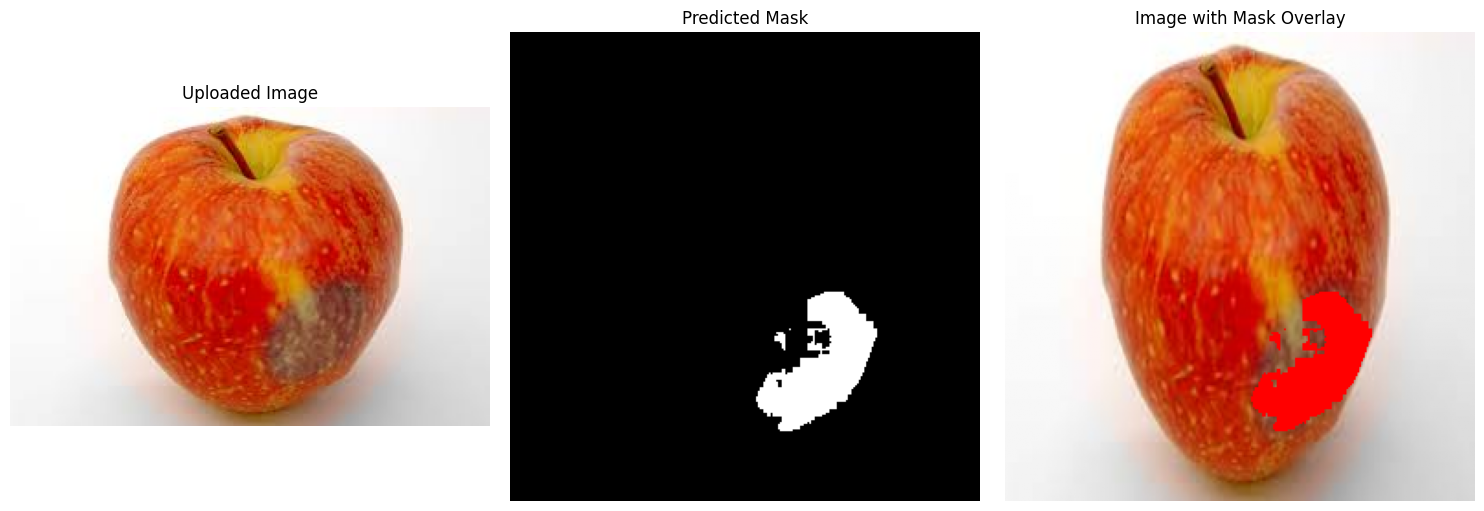

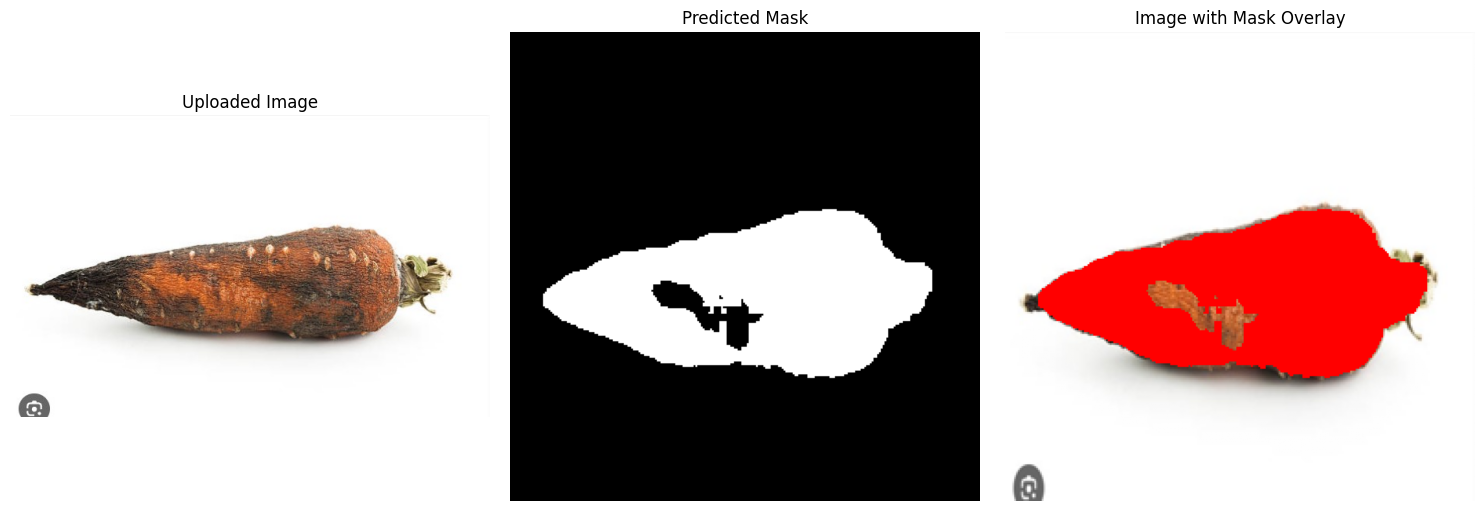

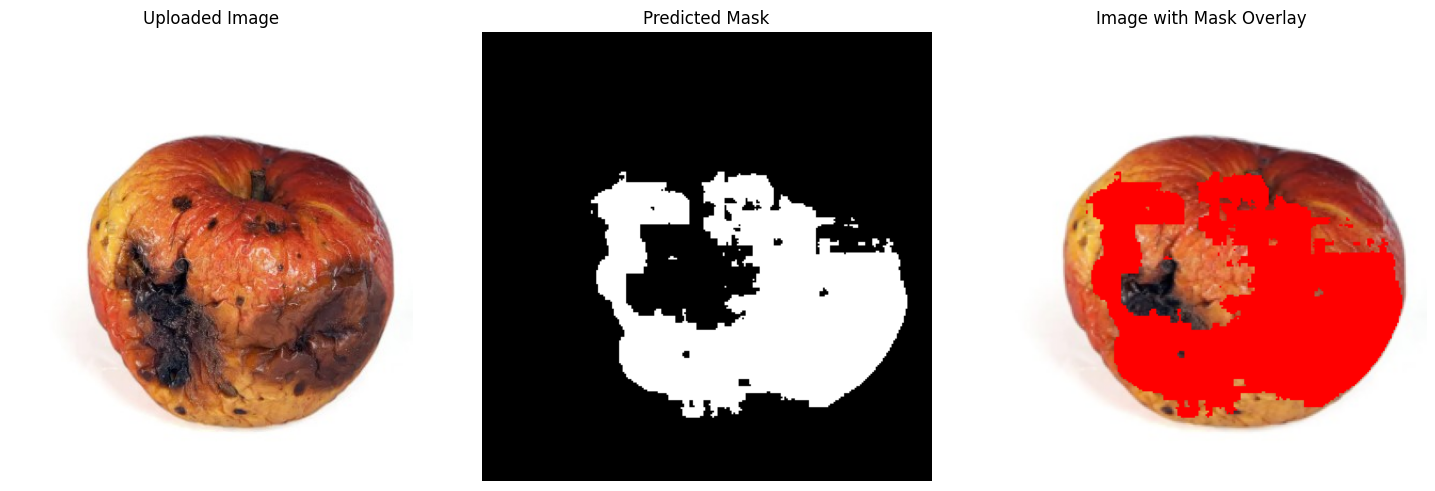

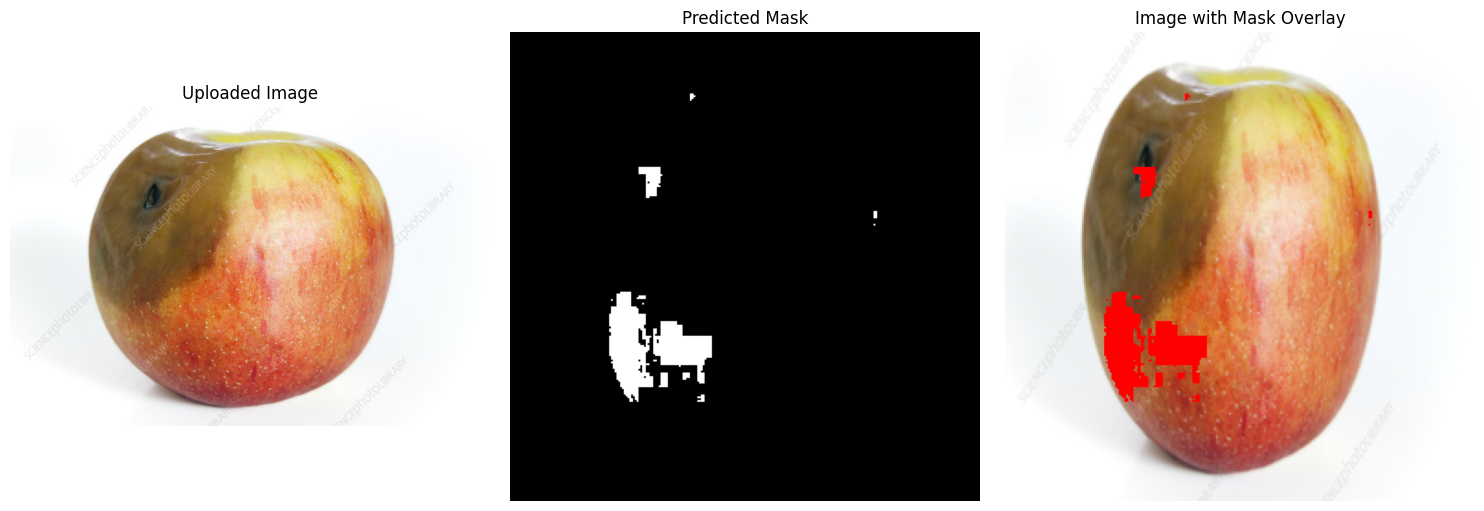

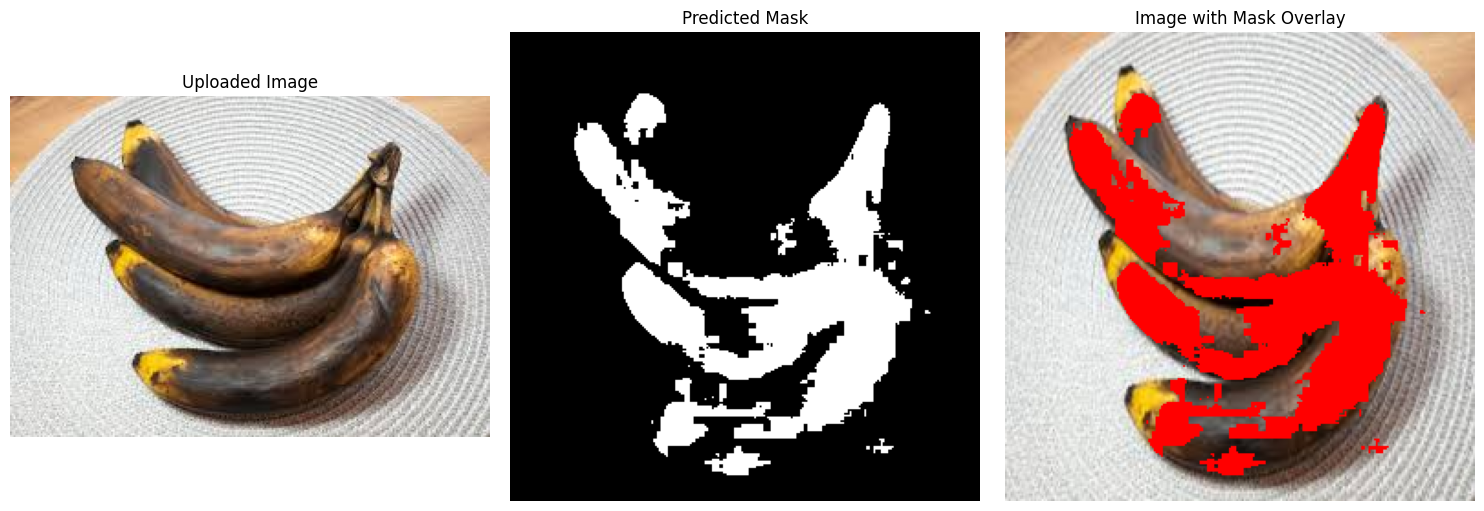

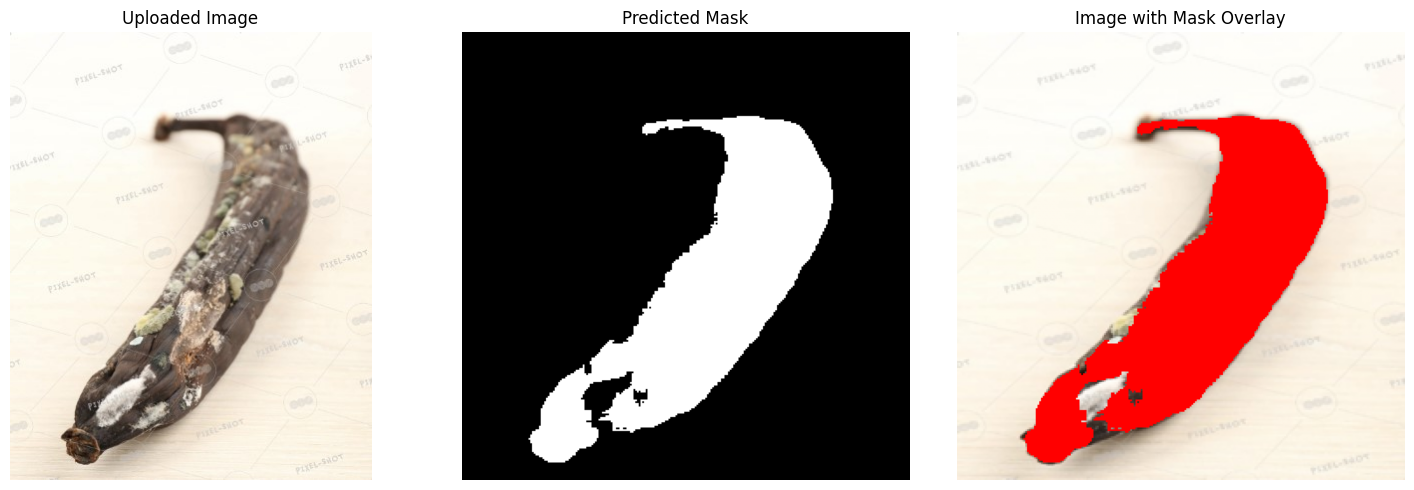

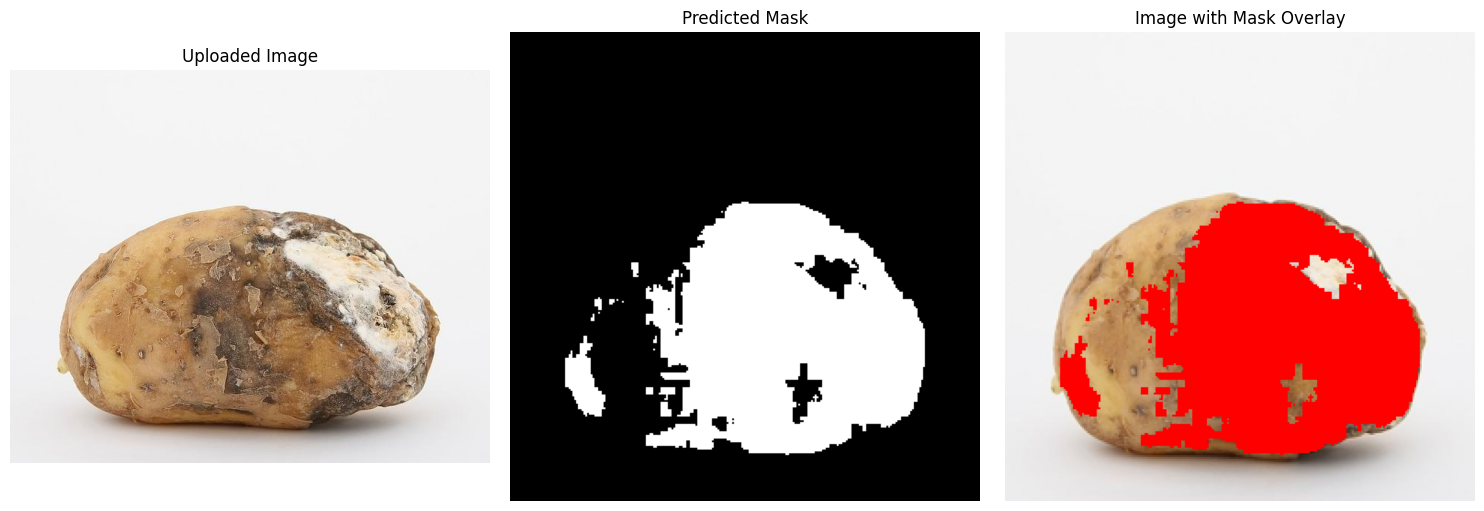

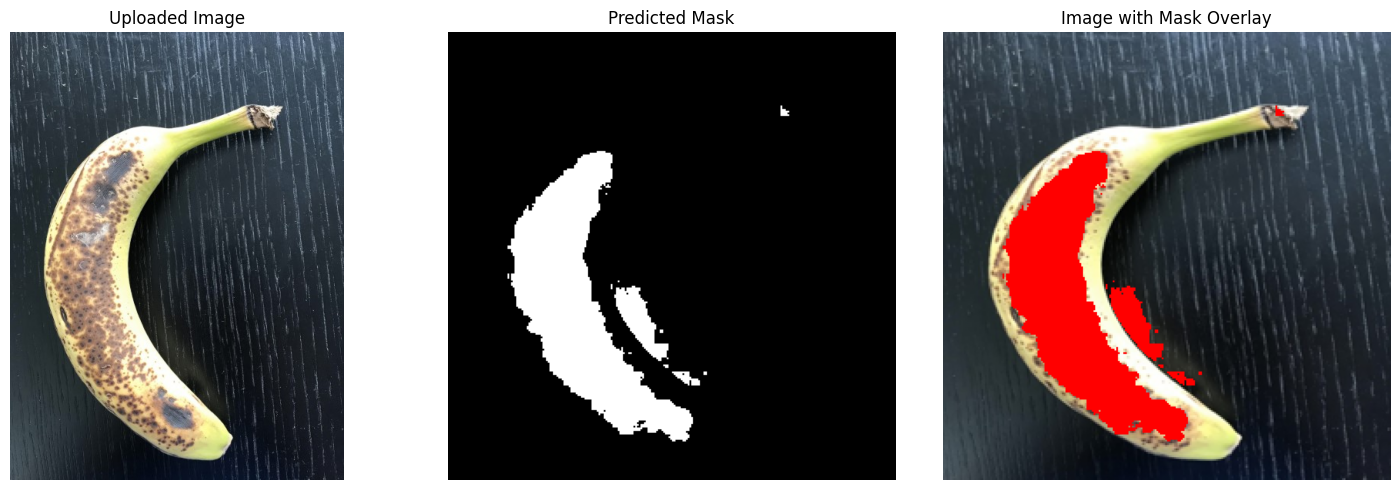

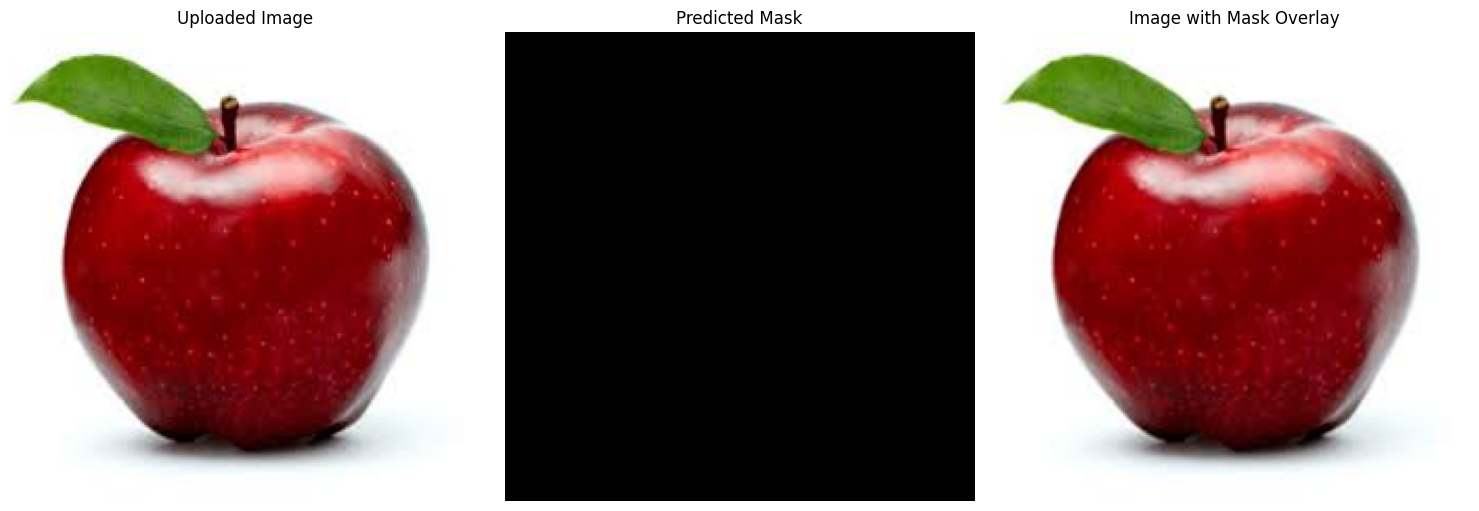

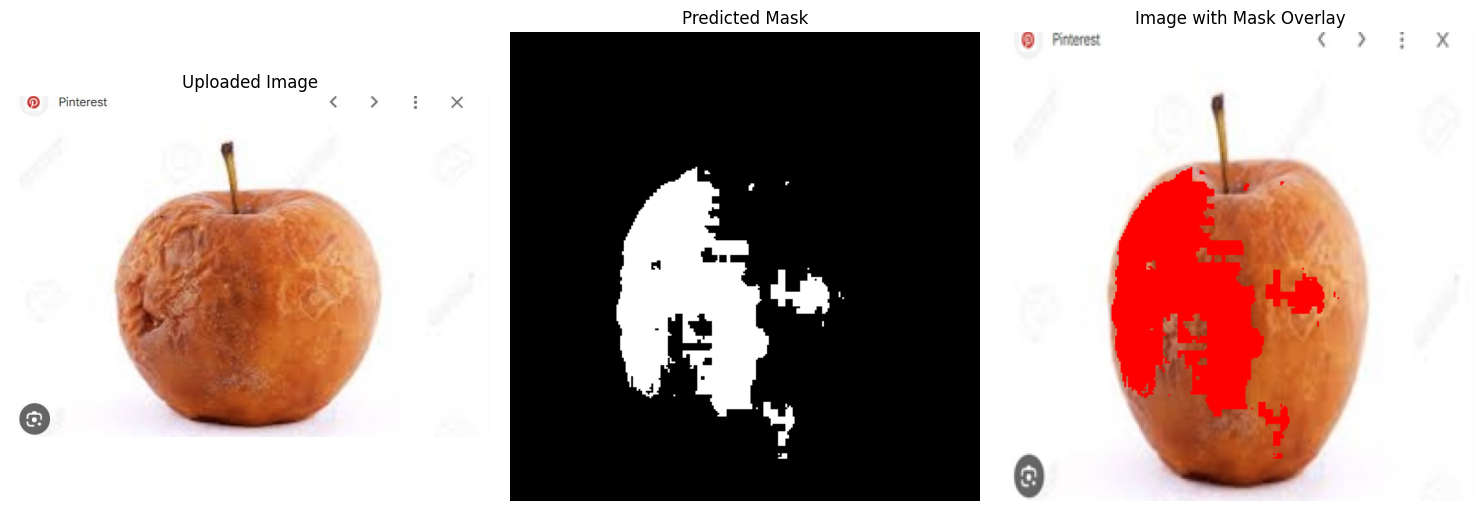

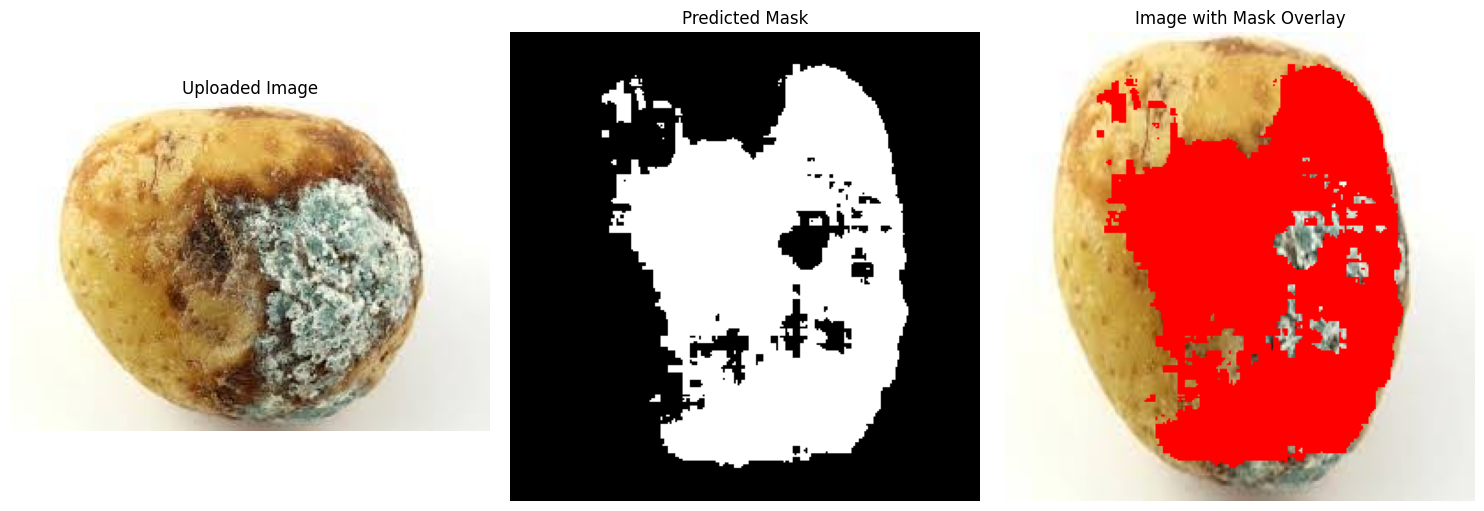

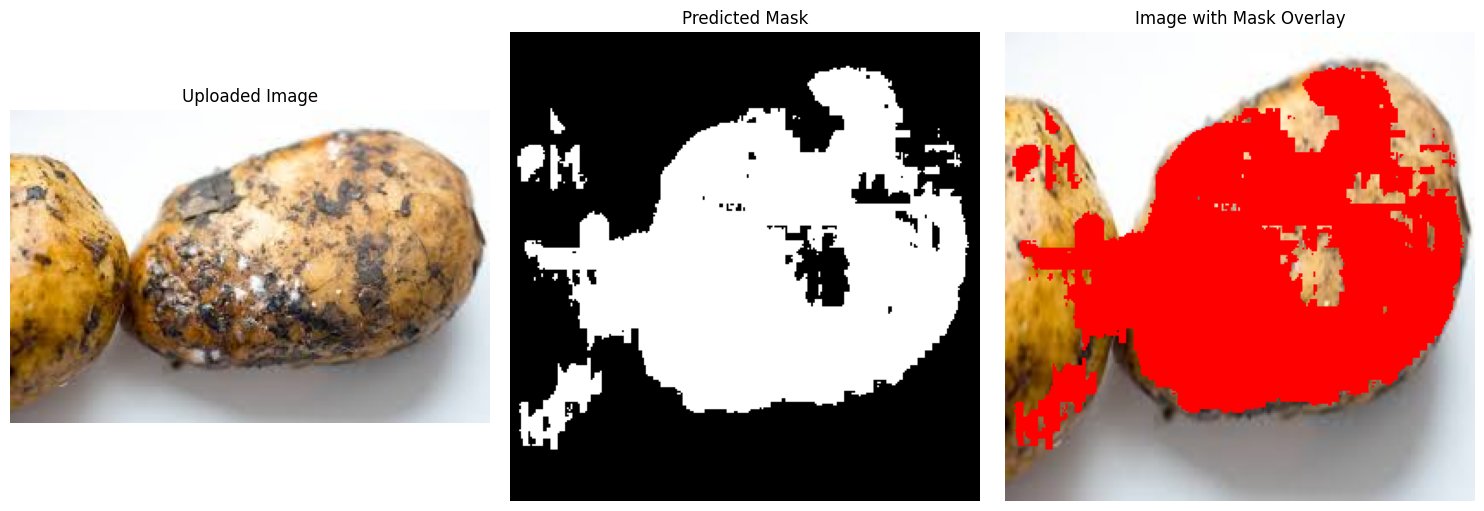

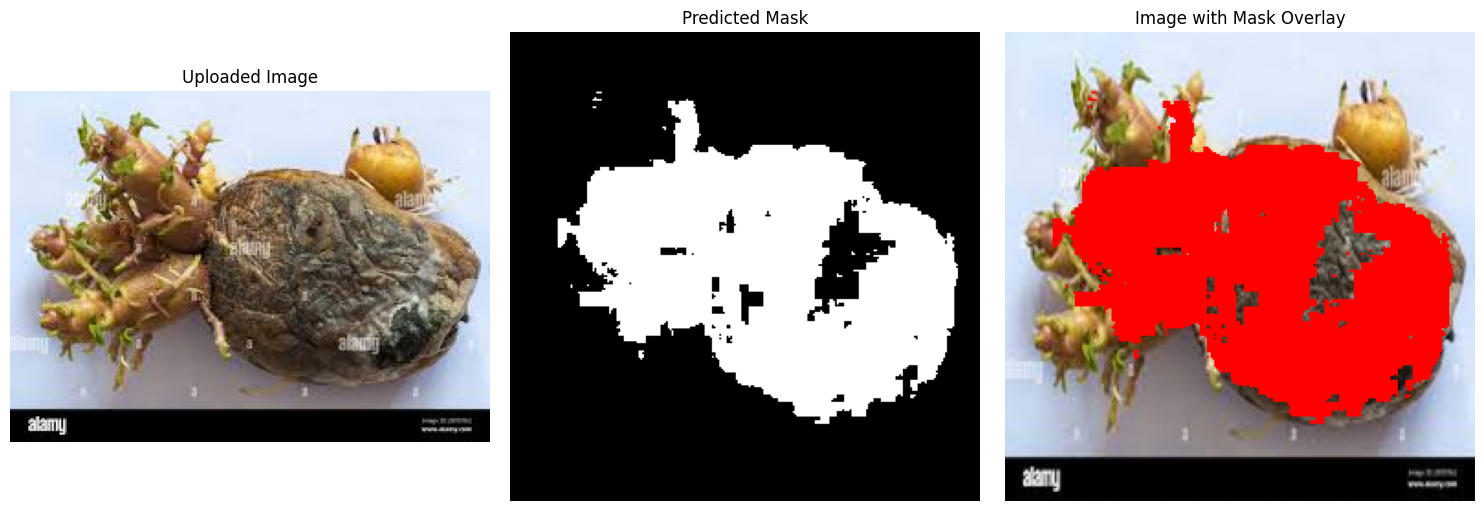

In [ ]:
model = UNet()
model.load_state_dict(torch.load("unet_model.pth", map_location=torch.device("cpu")))
model.eval()

def preprocess_image(img):
    img = img.convert("RGB").resize((256, 256))
    img_np = np.array(img) / 255.0
    img_tensor = torch.tensor(img_np).permute(2, 0, 1).unsqueeze(0).float()
    return img_tensor

def postprocess_mask(mask_tensor):
    mask_np = mask_tensor.squeeze().detach().numpy()
    return (mask_np > 0.5).astype(np.uint8)


upload = widgets.FileUpload(accept='.jpg,.jpeg,.png', multiple=False)
display(upload)

def on_upload_change(change):
    if upload.value and isinstance(upload.value, tuple):
        file_info = upload.value[0]
        content = file_info['content']
        image = Image.open(io.BytesIO(content))

        input_tensor = preprocess_image(image)
        with torch.no_grad():
            output = model(input_tensor)
        pred_mask = postprocess_mask(output)

        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(image)
        ax[0].set_title("Uploaded Image")
        ax[0].axis("off")

        ax[1].imshow(pred_mask, cmap="gray")
        ax[1].set_title("Predicted Mask")
        ax[1].axis("off")

        image_np = np.array(image.resize((256, 256))) / 255.0
        overlay = image_np.copy()
        overlay[pred_mask == 1] = [1, 0, 0]

        ax[2].imshow(overlay)
        ax[2].set_title("Image with Mask Overlay")
        ax[2].axis("off")

        plt.tight_layout()
        plt.show()

upload.observe(on_upload_change, names='value')

